## Load data

Spherical k-means 를 학습합니다.

In [1]:
import config
from navernews_10days import get_bow

x, idx_to_vocab, vocab_to_idx = get_bow(date='2016-10-20', tokenize='noun')
x.shape

soynlp=0.0.492
added lovit_textmining_dataset


(30091, 9774)

## TF-IDF transformation

많은 문서에서 등장하는 불필요한 단어들이 많다는 사전 지식이 있다면 TF-IDF 를 이용하여도 좋습니다. Scikit-learn 의 TfidfTransformer 의 결과값은 L2 row normalization 이 되어 있습니다.

In [2]:
from sklearn.feature_extraction.text import TfidfTransformer

x_tfidf = TfidfTransformer().fit_transform(x)

## Spherical k-means

[github.com/lovit/clustering4docs](github.com/lovit/clustering4docs) 의 코드를 이용하여 spherical k-means 를 학습합니다.

군집화나 토픽 모델링을 수행할 때에는 예상하는 것보다 군집/토픽의 개수를 크게 잡아주세요. 중복되는 군집이 등장하면 나중에 묶으면 됩니다. 하지만, 데이터에 노이즈가 있어서 다른 군집들이 하나의 군집으로 묶인다면 나중에 해석하기가 어려워집니다. 

특히, 여러 군집/토픽에서 자주 등장하는 단어들이 이러한 노이즈 역할을 합니다. 이런 단어들을 미리 걸러낼 수 있다면 훨씬 더 정교한 모델링이 될 것입니다. 즉, 군집화나 토픽모델링에서는 불필요하다 생각되는 단어들을 과감히 쳐낼수록 결과가 깔끔합니다. 그렇지 않다면, 군집화/토픽모델링을 할 때 군집/토픽의 개수를 크게 잡아두면 좀 더 좋습니다. 

In [3]:
import sys
sys.path.append('./clustering4docs/')

from soyclustering import SphericalKMeans

kmeans = SphericalKMeans(
    n_clusters = 200,
    init = 'similar_cut',
    verbose = True,
    random_state = 0,
)

labels = kmeans.fit_predict(x_tfidf)

initialization_time=0.284334 sec, sparsity=0.0071
n_iter=1, changed=29924, inertia=19900.518, iter_time=1.573 sec, sparsity=0.218
n_iter=2, changed=6564, inertia=15463.536, iter_time=1.564 sec, sparsity=0.195
n_iter=3, changed=2658, inertia=14856.927, iter_time=1.530 sec, sparsity=0.188
n_iter=4, changed=1365, inertia=14641.719, iter_time=1.520 sec, sparsity=0.184
n_iter=5, changed=776, inertia=14540.116, iter_time=1.496 sec, sparsity=0.182
n_iter=6, changed=553, inertia=14495.802, iter_time=1.496 sec, sparsity=0.181
n_iter=7, changed=388, inertia=14465.836, iter_time=1.519 sec, sparsity=0.18
n_iter=8, changed=251, inertia=14447.848, iter_time=1.510 sec, sparsity=0.18
n_iter=9, changed=190, inertia=14433.482, iter_time=1.547 sec, sparsity=0.179
n_iter=10, changed=166, inertia=14421.097, iter_time=1.533 sec, sparsity=0.179


Cluster centroid vectors 의 pairwise distance matrix 를 시각화 할 수 있습니다. 지금은 matplotlib 으로 구현되어 있는데, Bokeh 로 변환할 예정입니다.

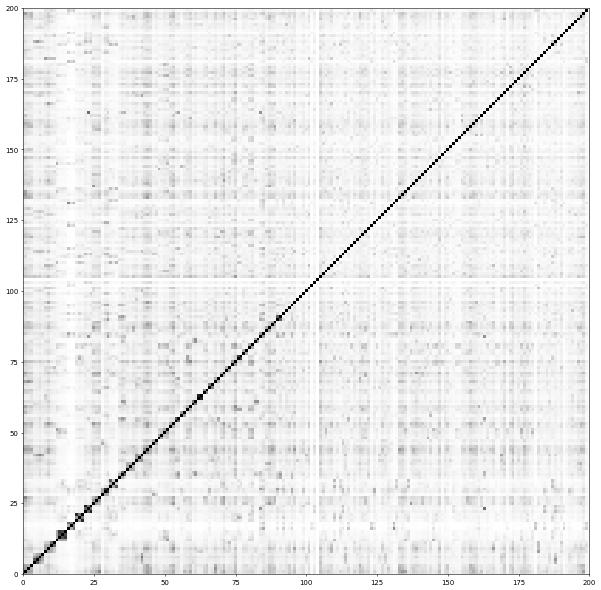

In [4]:
%matplotlib inline

from soyclustering import visualize_pairwise_distance

# visualize pairwise distance matrix
centers = kmeans.cluster_centers_
fig = visualize_pairwise_distance(centers, max_dist=.7, sort=True)
fig.savefig('2016-10-20-k200_pdist.png')

Centroids 간 cosine distance 가 0.5 를 넘지 않는 집합을 하나의 군집으로 묶습니다. 200 개의 군집이 180 개로 줄어들었으며, pairwise distance matrix 의 대각선이 더 진해집니다.

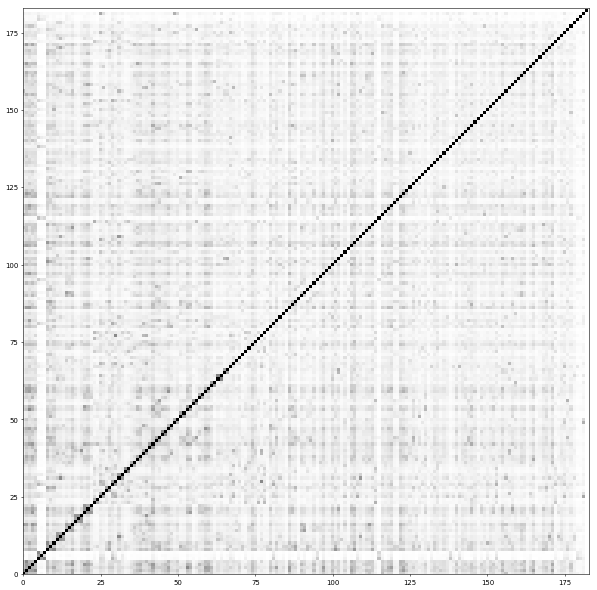

In [5]:
from soyclustering import merge_close_clusters

group_centers, groups = merge_close_clusters(centers, labels, max_dist=.5)
fig = visualize_pairwise_distance(group_centers, max_dist=.7, sort=True)
fig.savefig('2016-10-20-k200_post_pdist.png')

proportion keyword 방법을 이용하여 각 군집의 키워드를 레이블로 선택할 수도 있습니다.

In [6]:
from soyclustering import proportion_keywords

keywords = proportion_keywords(
    kmeans.cluster_centers_,
    labels,
    index2word=idx_to_vocab,
    topk=15,
    candidates_topk=30
)

./clustering4docs/soyclustering/_keyword.py:6: RuntimeWarning: invalid value encountered in true_divide
  l1_normalize = lambda x:x/x.sum()
./clustering4docs/soyclustering/_keyword.py:31: RuntimeWarning: invalid value encountered in greater
  indices = np.where(p_prop > 0)[0]


In [7]:
import numpy as np

for cidx, keyword in enumerate(keywords):
    keyword_strf = ', '.join(word for word, score in keyword)    
    cluster_size = np.where(labels == cidx)[0].shape[0]
    print('cluster #{} ({}): {}'.format(cidx, cluster_size, keyword_strf))
    if cidx % 5 == 4:
        print()

cluster #0 (159): 전국철도노동조합, 24일째, 철도파업, 홍기, 오봉역, 성과연봉제, 성과중심, 의왕, 의왕시, 양대, 연대, 최장기, 내륙, 금융권, 금융위원장
cluster #1 (58): 호스, 메디컬, 페어, 삼성동, 코엑스, 코넥스, 헬스케어, 취업박람회, 구직자들, 상장기업, 빌딩, 청담동, 창조, 더블, 코스닥
cluster #2 (127): 화물열차, 대체인력, 운행률, 화물연대, 코레일, 철도노조, 파업, 혼잡, 국비, 철도, 교섭, 운행, 화물, 노조, 최장기
cluster #3 (158): 11월호, 화보, 매거진, 시크, 몽환적, 오연서, 몸매, 소화, 눈빛, 메이크업, 면모, 발산, 돋보, 의상, 에이핑크
cluster #4 (74): 모술, 이라크, 탈환, 이슬람국가, 브렉시트, 총리, 작전, 메이, 이슬람, 저항, 외곽, 장악, 로이터, 영국, 탈출

cluster #5 (145): 우수상, 최우수상, 목재, 수상작, 특구, 상금, 수상자, 시상, 공로, 마크, 선정, 수여, 부부, 시상식, 부문
cluster #6 (131): 로베코샘, 지속가능경영, 다우존스, 지속가능성, 편입, 자금조달, 제일제당, 종합적, 상위, 스위스, 지표, 점수, 디스플레이, 측면, 사회적
cluster #7 (203): 13집, 블랙핑크, 휘파람, 씨엔블루, 신화, 음반, 빅스, 차트, 정규, 발매, 컴백, 앨범, 타이틀, 데뷔, 싱글
cluster #8 (124): 양구군, 전망대, 춘천시, 이진욱, 평창군, 장병들, 스카, 강원, 춘천, 평창, 황교안, 이정, 국무총리, 새누리당, 중동
cluster #9 (730): 430, 147, 165, 88, 108, 159, 13, 650, 2016, 43, 300, 99, 29, 25, 11

cluster #10 (332): 전용면적, 도시계획위원회, 1순위, 단지, 분양, 청약, 지상, 오피스텔, 경쟁률, 지하, 입주, 상가, 주거, 개통, 84
cluster #11 (114): 성남지

kmeans 의 centroid vectors 를 topic vector 로 이용하면 pyLDAVis 의 prepared data 를 만들 수 있습니다. 이를 이용하여 k-means 를 시각화 할 수 있습니다.

PyLDAVis 를 이용한 k-means 시각화 코드는 [https://github.com/lovit/kmeans_to_pyLDAvis](https://github.com/lovit/kmeans_to_pyLDAvis) 에 있습니다.

In [8]:
sys.path.append('./kmeans_to_pyLDAvis/')

import pyLDAvis
from kmeans_to_pyLDAvis import kmeans_to_prepared_data

prepared_data = kmeans_to_prepared_data(
    x, idx_to_vocab, kmeans.cluster_centers_, labels,
    embedding_method='pca'
)
pyLDAvis.display(prepared_data)

./kmeans_to_pyLDAvis/kmeans_to_pyLDAvis/proportion.py:99: RuntimeWarning: invalid value encountered in true_divide
  l1_normalize = lambda x:x/x.sum()
./kmeans_to_pyLDAvis/kmeans_to_pyLDAvis/proportion.py:136: RuntimeWarning: invalid value encountered in greater
  indices = np.where(p_prop > 0)[0]


In [9]:
# pyLDAvis.save_html(prepared_data, '2016-10-20-k200_pyldavis.html')